In [576]:
import numpy as np
import pandas as pd

In [577]:
df = pd.DataFrame()
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


<Axes: xlabel='X1', ylabel='X2'>

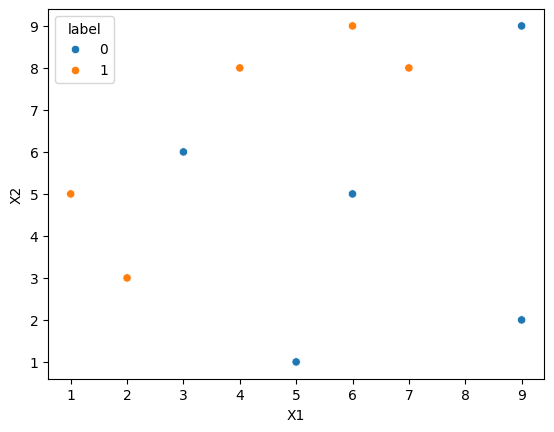

In [578]:
import seaborn as sns
sns.scatterplot(x=df['X1'], y=df['X2'], hue=df['label'])

# AdaBoost

In [579]:
df['weights'] = 1/df.shape[0]
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [580]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values

Train model

[Text(0.5, 0.75, 'x[0] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.625, 0.5, '  False')]

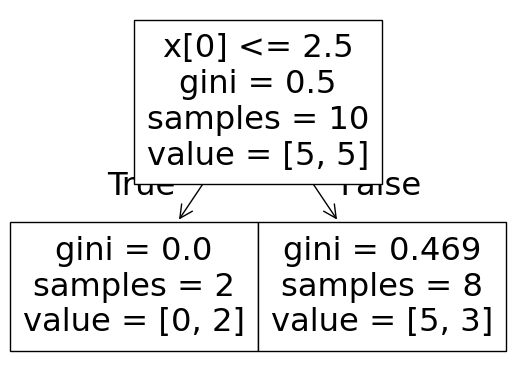

In [581]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X,y)
plot_tree(dt1)

<Axes: >

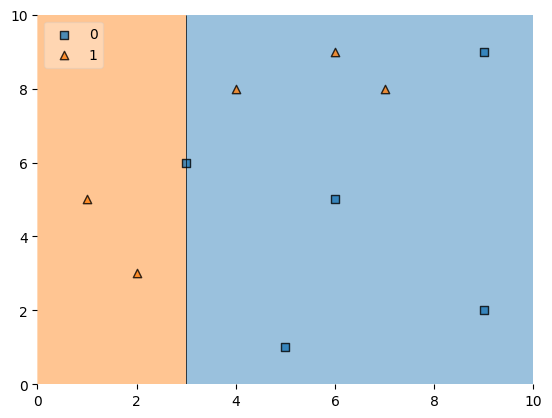

In [582]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X,y,clf=dt1,legend=2)

In [583]:
df['y_pred'] = dt1.predict(X)
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


calculate weight for the model

In [584]:
mask = df['label'] != df['y_pred']
error=np.round((df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha1 = calculate_model_weight(error)
alpha1

0.3


np.float64(0.42364893019360184)

Assign each row a weight

In [585]:
def calculate_model_weight(error):
  return 0.5*np.log((1-error)/error)

Update row weights

In [586]:
def update_row_weights(row, alpha):
  if row['label'] == row['y_pred']:
    return row['weights'] * np.exp(-alpha)
  else:
    return row['weights'] * np.exp(alpha)

In [587]:
df['updated_weights'] = df.apply(update_row_weights,axis=1, args=(alpha1,))     # axis =1 means applying function to each row
df

,X1,X2,label,weights,y_pred,updated_weights
0,1,5,1,0.1,1,0.065465
1,2,3,1,0.1,1,0.065465
2,3,6,0,0.1,0,0.065465
3,4,8,1,0.1,0,0.152753
4,5,1,0,0.1,0,0.065465
5,6,9,1,0.1,0,0.152753
6,6,5,0,0.1,0,0.065465
7,7,8,1,0.1,0,0.152753
8,9,9,0,0.1,0,0.065465
9,9,2,0,0.1,0,0.065465


Normalizing updated_weights

In [588]:
df['normalized_weights'] = df['updated_weights'] / df['updated_weights'].sum()
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights
0,1,5,1,0.1,1,0.065465,0.071429
1,2,3,1,0.1,1,0.065465,0.071429
2,3,6,0,0.1,0,0.065465,0.071429
3,4,8,1,0.1,0,0.152753,0.166667
4,5,1,0,0.1,0,0.065465,0.071429
5,6,9,1,0.1,0,0.152753,0.166667
6,6,5,0,0.1,0,0.065465,0.071429
7,7,8,1,0.1,0,0.152753,0.166667
8,9,9,0,0.1,0,0.065465,0.071429
9,9,2,0,0.1,0,0.065465,0.071429


In [589]:
df['cumsum_upper'] = np.cumsum(df['normalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalized_weights'] 
df = df[['X1','X2','label','weights','y_pred','updated_weights','normalized_weights','cumsum_lower','cumsum_upper']]
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.065465,0.071429,0.000000,0.071429
1,2,3,1,0.1,1,0.065465,0.071429,0.071429,0.142857
2,3,6,0,0.1,0,0.065465,0.071429,0.142857,0.214286
3,4,8,1,0.1,0,0.152753,0.166667,0.214286,0.380952
4,5,1,0,0.1,0,0.065465,0.071429,0.380952,0.452381
5,6,9,1,0.1,0,0.152753,0.166667,0.452381,0.619048
6,6,5,0,0.1,0,0.065465,0.071429,0.619048,0.690476
7,7,8,1,0.1,0,0.152753,0.166667,0.690476,0.857143
8,9,9,0,0.1,0,0.065465,0.071429,0.857143,0.928571
9,9,2,0,0.1,0,0.065465,0.071429,0.928571,1.000000


In [590]:
def create_new_dataset(df):
  indices = []
  
  for i in range(df.shape[0]):
    a = np.random.random()
    for index,row in df.iterrows():
      if row['cumsum_upper'] > a and a > row['cumsum_lower']:
        indices.append(index)

  return indices

In [591]:
index_values = create_new_dataset(df)
index_values

[5, 5, 2, 6, 4, 7, 7, 5, 2, 4]

In [592]:
second_df = df.iloc[index_values , [0,1,2,3]]
second_df

,X1,X2,label,weights
5,6,9,1,0.1
5,6,9,1,0.1
2,3,6,0,0.1
6,6,5,0,0.1
4,5,1,0,0.1
7,7,8,1,0.1
7,7,8,1,0.1
5,6,9,1,0.1
2,3,6,0,0.1
4,5,1,0,0.1


[Text(0.5, 0.75, 'x[1] <= 7.0\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.625, 0.5, '  False')]

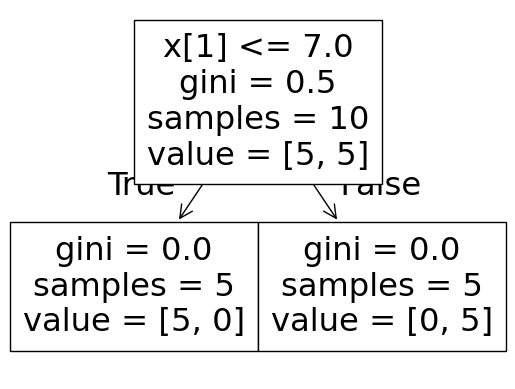

In [593]:
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt2 = DecisionTreeClassifier(max_depth=1)
dt2.fit(X,y)
plot_tree(dt2)

<Axes: >

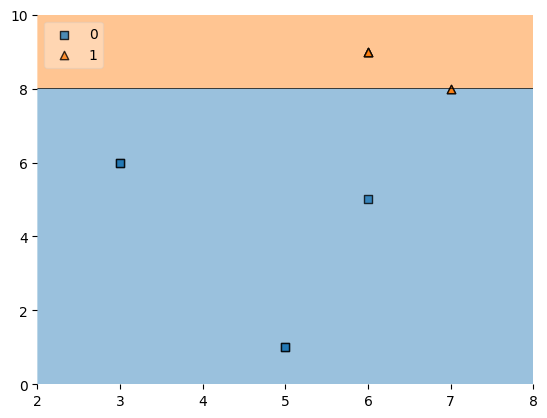

In [594]:
plot_decision_regions(X,y,clf=dt2 , legend =2)

In [595]:
second_df['y_pred'] = dt2.predict(X)
second_df

,X1,X2,label,weights,y_pred
5,6,9,1,0.1,1
5,6,9,1,0.1,1
2,3,6,0,0.1,0
6,6,5,0,0.1,0
4,5,1,0,0.1,0
7,7,8,1,0.1,1
7,7,8,1,0.1,1
5,6,9,1,0.1,1
2,3,6,0,0.1,0
4,5,1,0,0.1,0


In [596]:
mask = second_df['label'] != second_df['y_pred']
error=np.round((second_df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha2 = calculate_model_weight(error)
alpha2

0.0


C:\Users\Acer1\AppData\Local\Temp\ipykernel_19640\663092433.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5*np.log((1-error)/error)


np.float64(inf)

In [597]:
second_df['updated_weights'] = df.apply(update_row_weights,axis=1, args=(alpha2,))
second_df

,X1,X2,label,weights,y_pred,updated_weights
5,6,9,1,0.1,1,inf
5,6,9,1,0.1,1,inf
2,3,6,0,0.1,0,0.0
6,6,5,0,0.1,0,0.0
4,5,1,0,0.1,0,0.0
7,7,8,1,0.1,1,inf
7,7,8,1,0.1,1,inf
5,6,9,1,0.1,1,inf
2,3,6,0,0.1,0,0.0
4,5,1,0,0.1,0,0.0


In [598]:
second_df['normalized_weights'] = second_df['updated_weights'] / second_df['updated_weights'].sum()
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights
5,6,9,1,0.1,1,inf,NaN
5,6,9,1,0.1,1,inf,NaN
2,3,6,0,0.1,0,0.0,0.0
6,6,5,0,0.1,0,0.0,0.0
4,5,1,0,0.1,0,0.0,0.0
7,7,8,1,0.1,1,inf,NaN
7,7,8,1,0.1,1,inf,NaN
5,6,9,1,0.1,1,inf,NaN
2,3,6,0,0.1,0,0.0,0.0
4,5,1,0,0.1,0,0.0,0.0


In [599]:
second_df['normalized_weights'].sum()

np.float64(0.0)

In [600]:
second_df['cumsum_upper'] = np.cumsum(second_df['normalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalized_weights'] 
second_df = second_df[['X1','X2','label','weights','y_pred','updated_weights','normalized_weights','cumsum_lower','cumsum_upper']]
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_lower,cumsum_upper
5,6,9,1,0.1,1,inf,NaN,NaN,NaN
5,6,9,1,0.1,1,inf,NaN,NaN,NaN
2,3,6,0,0.1,0,0.0,0.0,0.0,0.0
6,6,5,0,0.1,0,0.0,0.0,0.0,0.0
4,5,1,0,0.1,0,0.0,0.0,0.0,0.0
7,7,8,1,0.1,1,inf,NaN,NaN,NaN
7,7,8,1,0.1,1,inf,NaN,NaN,NaN
5,6,9,1,0.1,1,inf,NaN,NaN,NaN
2,3,6,0,0.1,0,0.0,0.0,0.0,0.0
4,5,1,0,0.1,0,0.0,0.0,0.0,0.0


In [601]:
index_values = create_new_dataset(second_df)
index_values

[]

In [602]:
third_df = second_df.iloc[index_values , [0,1,2,3]]
third_df

,X1,X2,label,weights


In [603]:
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt3 = DecisionTreeClassifier(max_depth=1)
dt3.fit(X,y)


DecisionTreeClassifier(max_depth=1)

<Axes: >

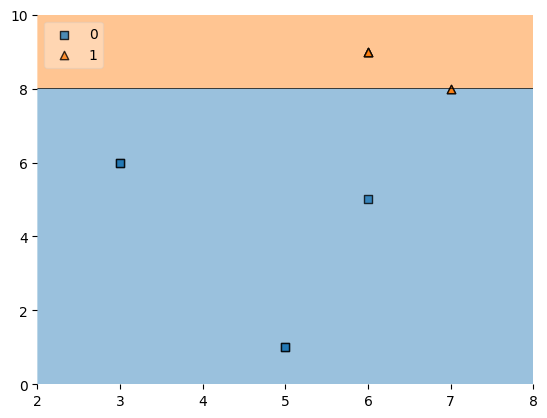

In [604]:
plot_decision_regions(X, y, clf=dt3, legend=2)


In [605]:
third_df['y_pred'] = dt3.predict(X)
third_df


,X1,X2,label,weights,y_pred
0,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,0
5,NaN,NaN,NaN,NaN,1
6,NaN,NaN,NaN,NaN,1
7,NaN,NaN,NaN,NaN,1
8,NaN,NaN,NaN,NaN,0
9,NaN,NaN,NaN,NaN,0


In [606]:
mask = second_df['label'] != second_df['y_pred']
error=np.round((second_df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha3 = calculate_model_weight(0.7)
alpha3

0.0


np.float64(-0.4236489301936017)

In [607]:
print(alpha1,alpha2,alpha3)


0.42364893019360184 inf -0.4236489301936017


In [608]:
query = np.array([1,5]).reshape(1,2)
dt1.predict(query)

array([1])

In [609]:
dt2.predict(query)


array([0])

In [610]:
dt3.predict(query)


array([0])

In [611]:
alpha1*1 + alpha2*(1) + alpha3*(1)


np.float64(inf)

In [612]:
np.sign(1.09)


np.float64(1.0)

In [613]:
query = np.array([9,9]).reshape(1,2)
dt1.predict(query)

array([0])

In [614]:
dt2.predict(query)


array([1])

In [615]:
dt3.predict(query)


array([1])

In [616]:
alpha1*(1) + alpha2*(-1) + alpha3*(-1)


np.float64(-inf)

In [617]:
np.sign(-0.25)


np.float64(-1.0)